In [1]:
#loading packages
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'infer' was built under R version 4.4.2"

Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp




In [2]:
#reading data and creating a new binary variable for whether a listing is greater than $700,000
#this is the population data
housing_raw <- read_delim(file = "HouseListings-Top45Cities-10292023-kaggle.csv", delim = ",")
threshold <- 700000
housing <- housing_raw |>
    mutate(above.threshold = if_else(Price > threshold, 1, 0))

Rows: 35768 Columns: 10
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): City, Address, Province
dbl (7): Price, Number_Beds, Number_Baths, Population, Latitude, Longitude, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#calculating recommended sample size to guarantee that the confidence interval
#for the proportion of listings above $700,000 has width equal to or less than 0.04
half.width <- 0.02
n <- ceiling(1.96^2 * (0.5) * (1-0.5) / half.width^2)
n

[1] 2401

In [4]:
#population size
N <- nrow(housing)
N

[1] 35768

In [5]:
#obtaining SRS
set.seed(123)
srs.sample <- housing[sample(N, n), ]
srs.sample

City,Price,Address,Number_Beds,Number_Baths,Province,Population,Latitude,Longitude,Median_Family_Income,above.threshold
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Calgary,1050000,132 Carrington Close NW,6,4,Alberta,1306784,51.0500,-114.0667,100000,1
Saint John,259900,9 Eastland Court,4,3,New Brunswick,69895,45.2806,-66.0761,74000,0
New Westminster,769900,1601-301 CAPILANO ROAD,2,2,British Columbia,78916,49.2069,-122.9111,82000,1
Calgary,429000,228 Rocky Ridge Court NW,3,2,Alberta,1306784,51.0500,-114.0667,100000,0
London,529000,384 WHARNCLIFFE Road S,5,3,Ontario,423369,42.9836,-81.2497,79500,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Hamilton,179000,60 Robinson Street,1,1,Ontario,729560,43.2567,-79.8692,91000,0
Vancouver,1899000,4416 PRICE CRESCENT,4,3,British Columbia,2426160,49.2500,-123.1000,90000,1
Victoria,435000,303-611 Brookside Rd,1,1,British Columbia,363222,48.4283,-123.3647,85000,0


In [6]:
#SRS estimate of the mean price
srs.price.est <- mean(srs.sample$Price)
srs.price.est

[1] 930395.5

In [7]:
#SE for the mean price estimated via SRS
srs.price.SE <- sd(srs.sample$Price)/sqrt(n)
srs.price.SE

[1] 19088.64

In [8]:
#SRS confidence interval for the mean price
srs.price.lowerCI <- srs.price.est - 1.96 * srs.price.SE
srs.price.lowerCI
srs.price.upperCI <- srs.price.est + 1.96 * srs.price.SE
srs.price.upperCI

[1] 892981.7

[1] 967809.2

In [9]:
#SRS estimate of the proportion of listings greater than $700,000
srs.prop.est <- mean(srs.sample$above.threshold)
srs.prop.est

[1] 0.4798001

In [10]:
#SE for the proportion of listings greater than $700,000 estimated via SRS
srs.prop.SE <- sqrt(srs.prop.est * (1 - srs.prop.est)/n)
srs.prop.SE

[1] 0.01019575

In [11]:
#SRS confidence interval for the proportion of listings greater than $700,000
srs.prop.lowerCI <- srs.prop.est - 1.96 * srs.prop.SE
srs.prop.lowerCI
srs.prop.upperCI <- srs.prop.est + 1.96 * srs.prop.SE
srs.prop.upperCI

[1] 0.4598164

[1] 0.4997838

In [12]:
num.strata <- 45

#determining sample size for each strata using proportional 
#allocation, split into integer and decimal components
strata.sizes <- housing |> 
    count(City) |> 
    rename(N.h = n) |>
    mutate(N.prop.h = N.h/N) |>
    mutate(n.h = N.h*n/N) |>
    mutate(decimal = n.h - floor(n.h)) |>
    mutate(n.h = floor(n.h))

#remaining observations to allocate
leftover.obs <- n - sum(strata.sizes$n.h)

#Ranking strata by decimal component and allocating an extra observation to the 
#strata with the largest decimal components. This ensures that the SRS and the 
#stratified sample have the same sample size, which is not the case if we were to 
#simply round the calculated sample size for each strata to the nearest integer.
ranks <- row_number(strata.sizes$decimal)
strata.sizes <- cbind(strata.sizes, ranks) |>
    mutate(extra.obs = if_else(ranks > num.strata - leftover.obs, 1, 0))

#population and sample size of each strata
strata.sizes <- strata.sizes |>
    mutate(n.h = n.h + extra.obs) |>
    select(City:n.h)

strata.sizes

City,N.h,N.prop.h,n.h
<chr>,<int>,<dbl>,<dbl>
Abbotsford,755,0.021108253,51
Airdrie,225,0.006290539,15
Barrie,1012,0.028293447,68
Brantford,628,0.017557593,42
Burnaby,1334,0.037295907,89
⋮,⋮,⋮,⋮
Vancouver,1328,0.03712816,89
Victoria,1325,0.03704429,89
White Rock,1175,0.03285059,79


In [13]:
#obtaining stratified sample
str.sample <- NULL
strata.summaries <- NULL
set.seed(420)
for (i in 1:nrow(strata.sizes)) {
    pop.h <- filter(housing, City == strata.sizes$City[i])
    sample.h <- sample_n(pop.h, strata.sizes$n.h[i], replace = FALSE)
    str.sample <- rbind(str.sample, sample.h)
    summary <- summarize(sample.h, priceAVG = mean(Price), priceSE = sd(Price), prop = mean(above.threshold))
    strata.summaries <- rbind(strata.summaries, summary)
}
str.sample

City,Price,Address,Number_Beds,Number_Baths,Province,Population,Latitude,Longitude,Median_Family_Income,above.threshold
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abbotsford,565000,305-2565 CAMPBELL AVENUE,3,2,British Columbia,153524,49.05,-122.3167,91000,0
Abbotsford,950000,2699 MITCHELL STREET,5,3,British Columbia,153524,49.05,-122.3167,91000,1
Abbotsford,1130000,32098 AUSTIN AVENUE,5,2,British Columbia,153524,49.05,-122.3167,91000,1
Abbotsford,1349700,36090 SOUTHRIDGE PLACE,4,3,British Columbia,153524,49.05,-122.3167,91000,1
Abbotsford,849900,2052 OAKRIDGE CRESCENT,3,1,British Columbia,153524,49.05,-122.3167,91000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Winnipeg,425000,39 Highcastle Crescent,4,3,Manitoba,758515,49.8844,-97.1464,83000,0
Winnipeg,369900,202-90 Bole Street,2,2,Manitoba,758515,49.8844,-97.1464,83000,0
Winnipeg,169500,3-1525 Chancellor Drive,1,1,Manitoba,758515,49.8844,-97.1464,83000,0


In [14]:
#calculating estimates and SE's for both variables of interest from each strata
options(repr.matrix.max.rows = 45)
strata.info <- str.sample |>
    group_by(City) |>
    summarize(priceAVG = mean(Price), priceSE = sd(Price), prop = mean(above.threshold)) |>
    cbind(strata.sizes) |>
    select(-5) |>
    mutate(priceSE = priceSE / sqrt(n.h)) |>
    mutate(propSE = sqrt(prop * (1 - prop) / n.h))
strata.info

City,priceAVG,priceSE,prop,N.h,N.prop.h,n.h,propSE
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Abbotsford,1454707.3,207343.00,0.74509804,755,0.021108253,51,0.06102506
Airdrie,699813.3,79773.86,0.53333333,225,0.006290539,15,0.12881224
Barrie,1159746.8,197344.25,0.75000000,1012,0.028293447,68,0.05251050
Brantford,900254.6,57814.26,0.64285714,628,0.017557593,42,0.07393560
Burnaby,1326360.2,101661.62,0.70786517,1334,0.037295907,89,0.04820276
Caledon,1287134.4,75931.14,0.83333333,1336,0.037351823,90,0.03928371
Calgary,583603.5,35660.64,0.20224719,1322,0.036960412,89,0.04257753
Edmonton,463932.9,37231.79,0.16483516,1351,0.037771192,91,0.03889469
Guelph,964966.0,133308.80,0.41379310,436,0.012189667,29,0.09145724


In [15]:
#stratified estimate of the mean price
str.price.est <- sum(strata.info$priceAVG*strata.info$N.prop.h)
str.price.est

[1] 926995.7

In [16]:
#SE for the mean price estimated via stratified sampling
str.price.SE <- sqrt(sum(strata.info$priceSE^2*strata.info$N.prop.h^2))
str.price.SE

[1] 16168.81

In [17]:
#stratified confidence interval for the mean price
str.price.lowerCI <- str.price.est - 1.96 * str.price.SE
str.price.lowerCI
str.price.upperCI <- str.price.est + 1.96 * str.price.SE
str.price.upperCI

[1] 895304.9

[1] 958686.6

In [18]:
#stratified estimate of the proportion of listings greater than $700,000
str.prop.est <- sum(strata.info$prop*strata.info$N.prop.h)
str.prop.est

[1] 0.4932235

In [19]:
#SE for the proportion of listings greater than $700,000 estimated via stratified sampling
str.prop.SE <- sqrt(sum(strata.info$propSE^2*strata.info$N.prop.h^2))
str.prop.SE

[1] 0.008590149

In [20]:
#stratified confidence interval for the proportion of listings greater than $700,000
str.prop.lowerCI <- str.prop.est - 1.96 * str.prop.SE
str.prop.lowerCI
str.prop.upperCI <- str.prop.est + 1.96 * str.prop.SE
str.prop.upperCI

[1] 0.4763868

[1] 0.5100602

In [21]:
#comparing estimates of the mean price from SRS and stratified sampling
tibble("Sampling Method" = c("SRS", "STR"),
       "Estimated Mean Price" = c(srs.price.est, str.price.est),
       "SE" = c(srs.price.SE, str.price.SE),
       "Lower CI" = c(srs.price.lowerCI, str.price.lowerCI),
       "Upper CI" = c(srs.price.upperCI, str.price.upperCI))

Sampling Method,Estimated Mean Price,SE,Lower CI,Upper CI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SRS,930395.5,19088.64,892981.7,967809.2
STR,926995.7,16168.81,895304.9,958686.6


In [22]:
#comparing estimates of the proportion of listings greater than $700,000 from SRS and stratified sampling
tibble("Sampling Method" = c("SRS", "STR"),
       "Estimated Proportion of Listings Above 700k" = c(srs.prop.est, str.prop.est),
       "SE" = c(srs.prop.SE, str.prop.SE),
       "Lower CI" = c(srs.prop.lowerCI, str.prop.lowerCI),
       "Upper CI" = c(srs.prop.upperCI, str.prop.upperCI))

Sampling Method,Estimated Proportion of Listings Above 700k,SE,Lower CI,Upper CI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SRS,0.4798001,0.010195751,0.4598164,0.4997838
STR,0.4932235,0.008590149,0.4763868,0.5100602


In [23]:
#distribution of listing price from SRS
options(repr.plot.width = 10,repr.plot.height = 6)
srs.plot.unbounded <- srs.sample |>
    ggplot(aes(x = Price)) +
    geom_histogram(binwidth = 500000, fill = "#00BFCF", col = "black") + 
    theme(text = element_text(size = 20)) + 
    labs(x = "Price in Millions (CAD)", y = "Count", title = "SRS Distribution of Price, Unbounded Axis") +
    geom_vline(xintercept = threshold, color = "red", linewidth = 1.5) +
    scale_x_continuous(
        breaks = seq(from = 0, to = 20000000, by = 5000000),
        label = c(0, 5, 10, 15, 20)
    )

In [24]:
#distribution of listing price from SRS, price bounded between 0 and 3 million
options(repr.plot.width = 10,repr.plot.height = 6)
srs.plot.bounded <- srs.sample |>
    ggplot(aes(x = Price)) +
    geom_histogram(binwidth = 100000, fill = "#00BFCF", col = "black") + 
    theme(text = element_text(size = 20)) + 
    labs(x = "Price", y = "Count", title = "SRS Distribution of Price, Bounded Axis") +
    geom_vline(xintercept = threshold, color = "red", linewidth = 1.5) + 
    scale_x_continuous(
        limits = c(-50000, 3050000), 
        breaks = seq(from = 0, to = 3000000, by = 500000),
        label = c(0, 0.5, 1, 1.5, 2, 2.5, 3)
    )

In [25]:
#distribution of listing price from stratified sample
options(repr.plot.width = 10,repr.plot.height = 6)
str.plot.unbounded <- str.sample |>
    ggplot(aes(x = Price)) +
    geom_histogram(binwidth = 500000, fill = "#00BFCF", col = "black") + 
    theme(text = element_text(size = 20)) + 
    labs(x = "Price", y = "Count", title = "STR Distribution of Price, Unbounded Axis") +
    geom_vline(xintercept = threshold, color = "red", linewidth = 1.5) +
    scale_x_continuous(
        breaks = seq(from = 0, to = 20000000, by = 5000000),
        label = c(0, 5, 10, 15, 20)
    )

In [26]:
#distribution of listing price from stratified sample, price bounded between 0 and 3 million
options(repr.plot.width = 10,repr.plot.height = 6)
str.plot.bounded <- str.sample |>
    ggplot(aes(x = Price)) +
    geom_histogram(binwidth = 100000, fill = "#00BFCF", col = "black") + 
    theme(text = element_text(size = 20)) + 
    labs(x = "Price", y = "Count", title = "STR Distribution of Price, Bounded Axis") +
    geom_vline(xintercept = threshold, color = "red", linewidth = 1.5) +
    scale_x_continuous(
        limits = c(-50000, 3050000), 
        breaks = seq(from = 0, to = 3000000, by = 500000),
        label = c(0, 0.5, 1, 1.5, 2, 2.5, 3)
    )

Warning message:
"Removed 55 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 57 rows containing non-finite outside the scale range (`stat_bin()`)."


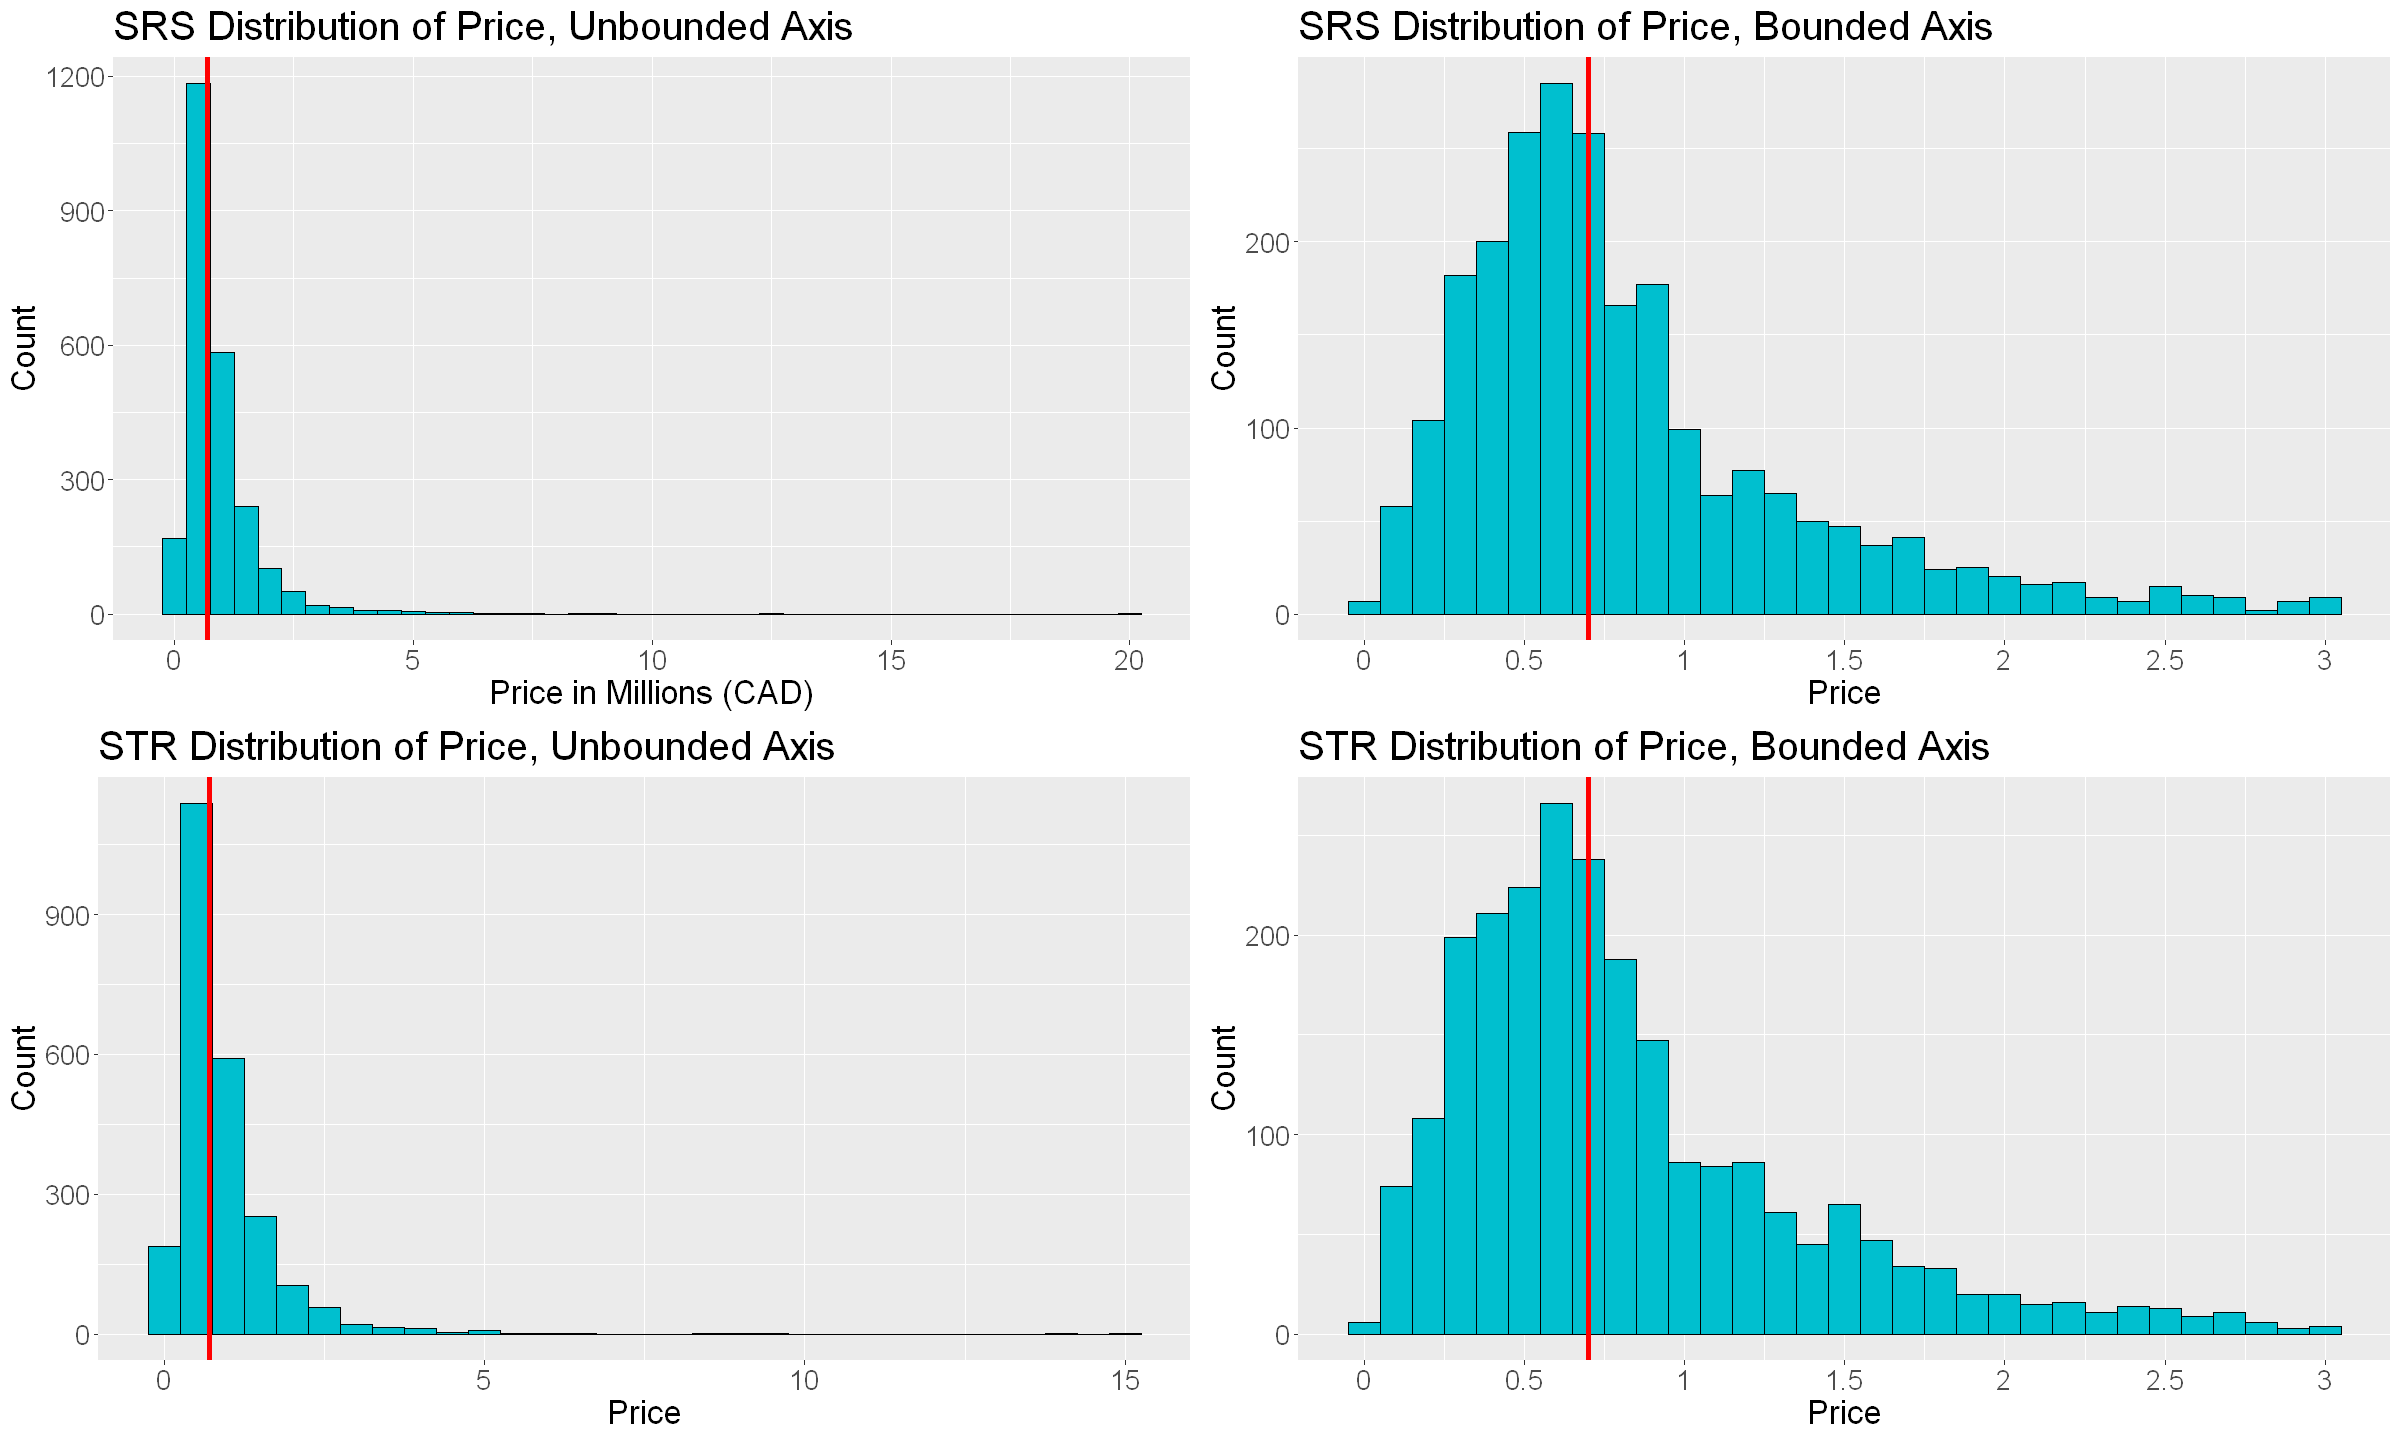

In [27]:
#arranging plots in a 2x2 grid
options(repr.plot.width=20,repr.plot.height=12)
plots <- plot_grid(srs.plot.unbounded, srs.plot.bounded, str.plot.unbounded, str.plot.bounded)
plots

Warning message:
"Removed 55 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 57 rows containing non-finite outside the scale range (`stat_bin()`)."


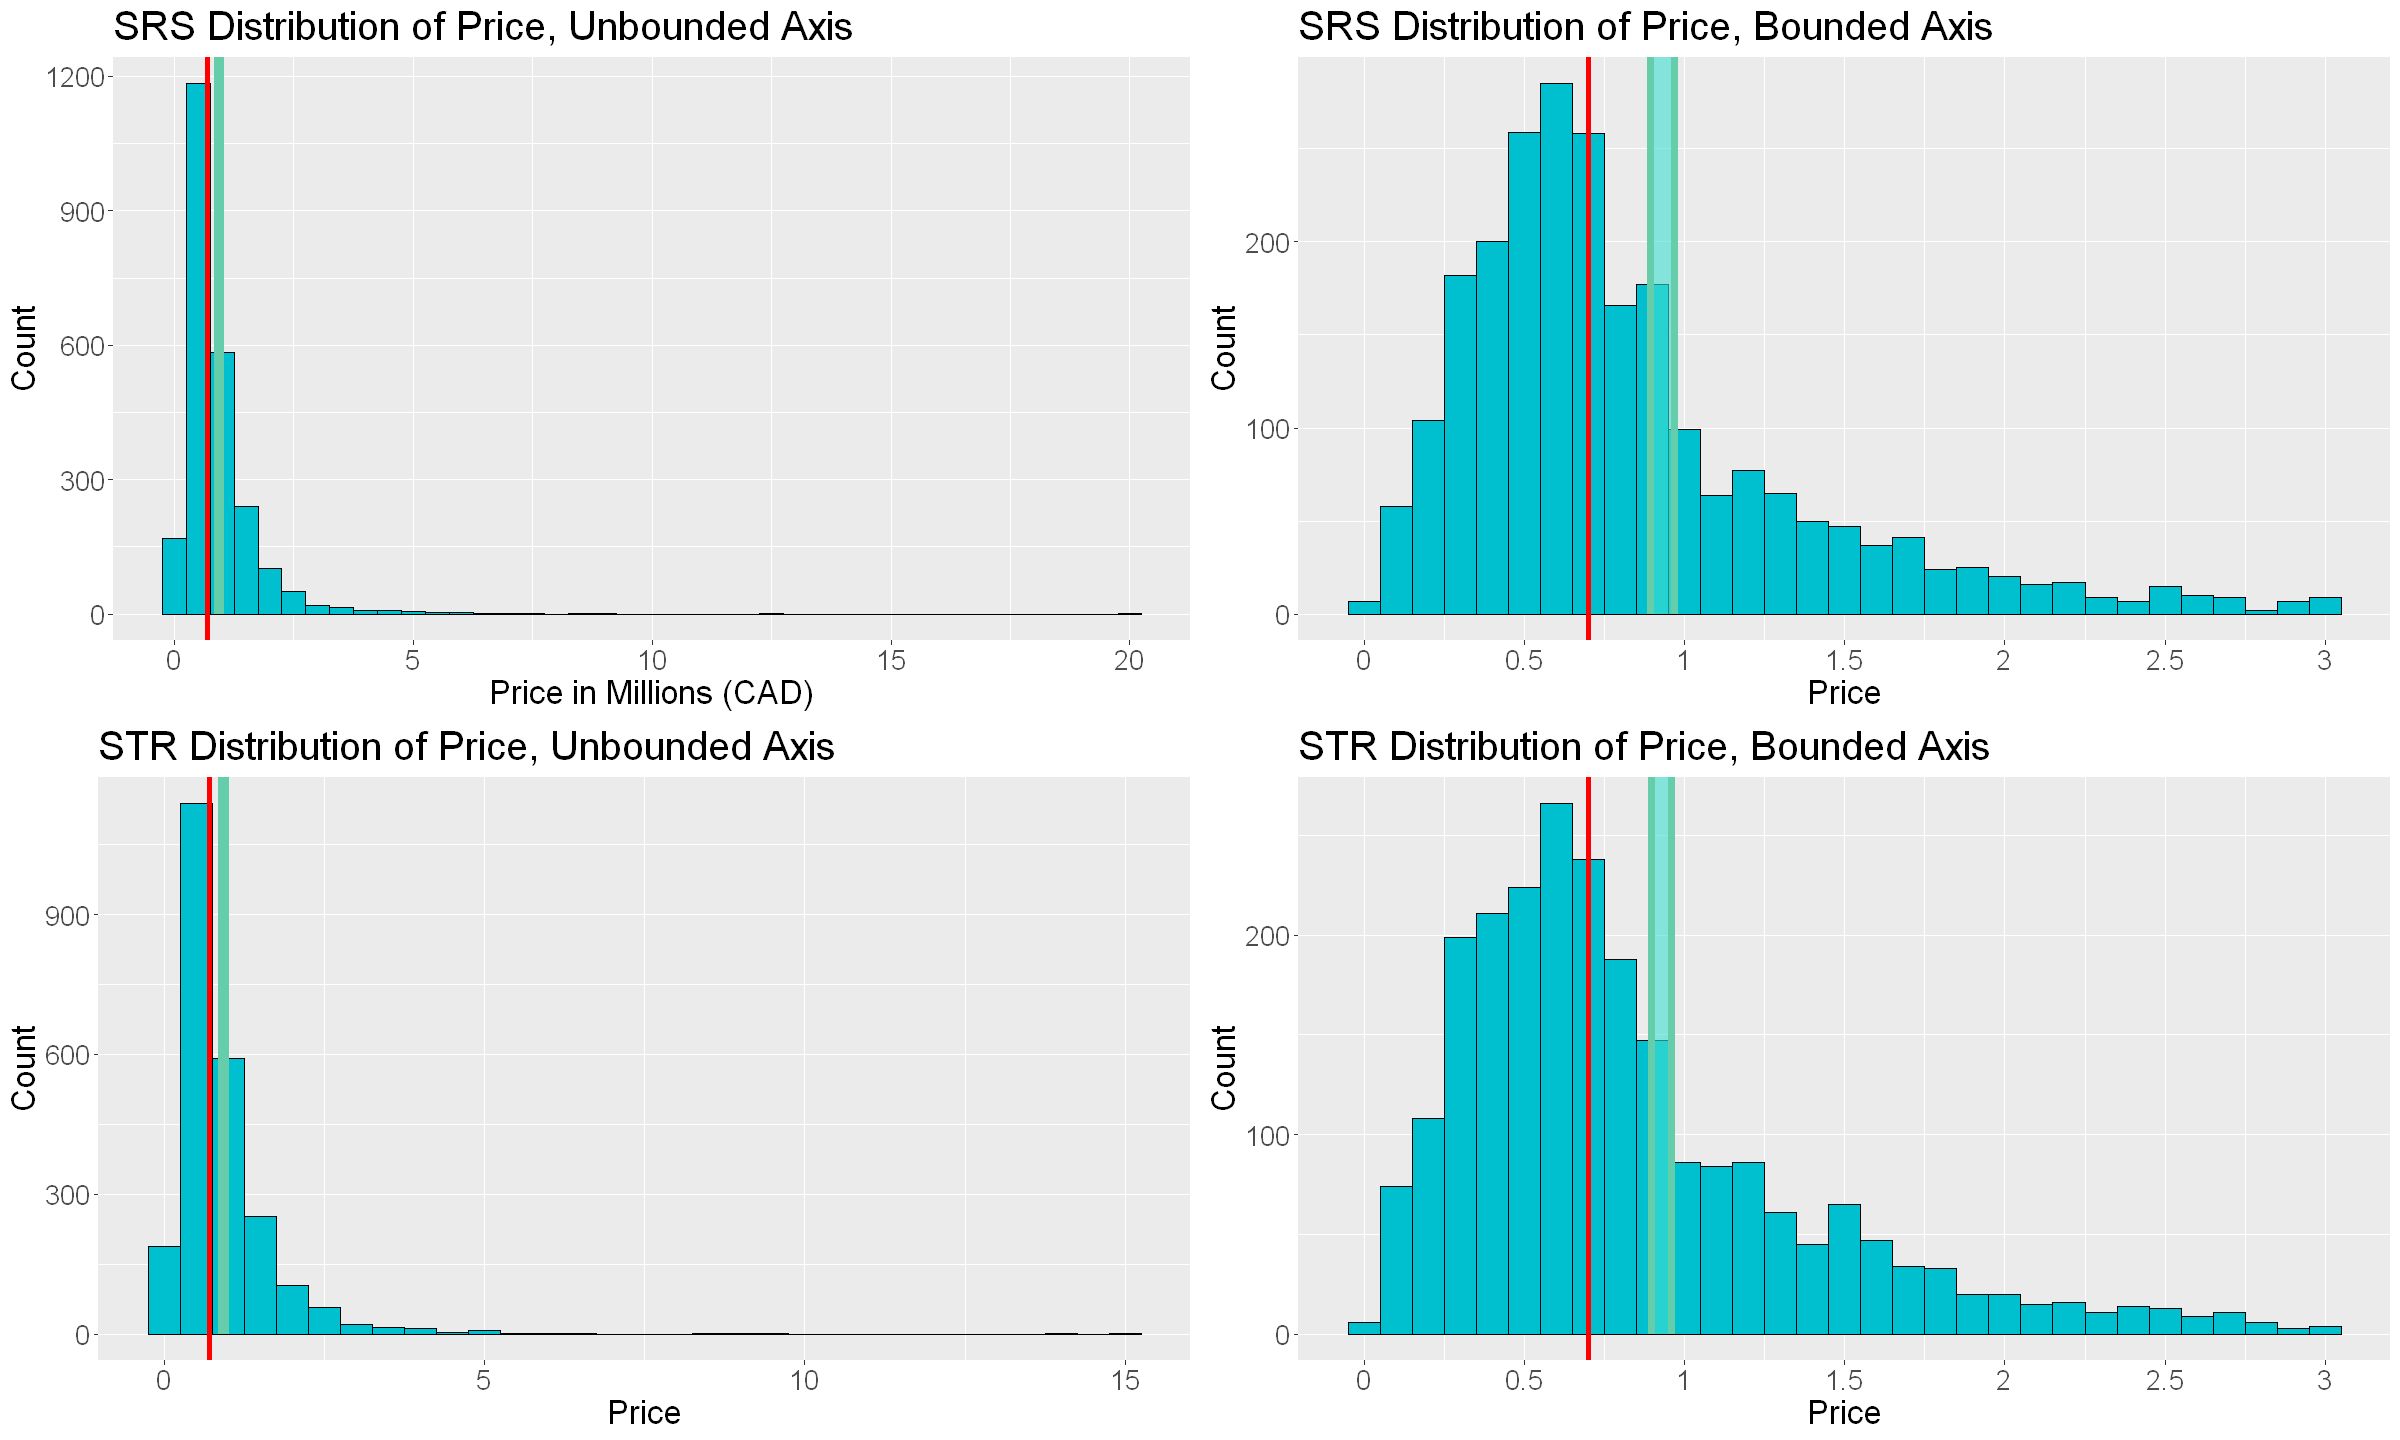

In [28]:
#same plots as before but with the appropriate confidence intervals shaded
srs.plot.ci.unbounded <- srs.plot.unbounded + shade_ci(endpoints = c(srs.price.lowerCI, srs.price.upperCI))

srs.plot.ci.bounded <- srs.plot.bounded + shade_ci(endpoints = c(srs.price.lowerCI, srs.price.upperCI))

str.plot.ci.unbounded <- str.plot.unbounded + shade_ci(endpoints = c(str.price.lowerCI, str.price.upperCI))

str.plot.ci.bounded <- str.plot.bounded + shade_ci(endpoints = c(str.price.lowerCI, str.price.upperCI))

options(repr.plot.width=20,repr.plot.height=12)
plots.ci <- plot_grid(srs.plot.ci.unbounded, srs.plot.ci.bounded, str.plot.ci.unbounded, str.plot.ci.bounded)
plots.ci